## Q1: SiamFC Object Tracking

In [1]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras import layers, models
from PIL import Image

# ---------- SiamFC Network Definition ----------
class SiamFC(tf.keras.Model):
    def __init__(self):
        super(SiamFC, self).__init__()
        self.backbone = models.Sequential([
            layers.Input(shape=(127, 127, 3)),
            layers.Conv2D(96, kernel_size=11, strides=2, activation='relu'),
            layers.MaxPooling2D(pool_size=3, strides=2),
            layers.Conv2D(256, kernel_size=5, activation='relu'),
            layers.MaxPooling2D(pool_size=3, strides=2),
            layers.Conv2D(384, kernel_size=3, activation='relu'),
            layers.Conv2D(384, kernel_size=3, activation='relu'),
            layers.Conv2D(256, kernel_size=3),
        ])

    def xcorr(self, z, x):
        """Cross-correlation using depthwise convolution"""
        # Convert z to filter shape (filter_height, filter_width, in_channels, out_channels)
        filters = tf.transpose(z, [1, 2, 3, 0])
        return tf.nn.conv2d(x, filters, strides=1, padding='VALID')

    def call(self, template, search):
        z = self.backbone(template)
        x = self.backbone(search)
        out = self.xcorr(z, x)
        return out

# ---------- Helper Functions ----------
def get_patch(img, center, size):
    cx, cy = center
    w, h = size
    x1 = int(cx - w / 2)
    y1 = int(cy - h / 2)
    x2 = x1 + w
    y2 = y1 + h
    patch = img[y1:y2, x1:x2]
    patch = cv2.resize(patch, (127, 127))
    patch = patch.astype(np.float32) / 255.0
    return patch

# ---------- Load Video and Template ----------
video_path = 'sample_tracking_video.mp4'
cap = cv2.VideoCapture(video_path)

ret, first_frame = cap.read()
init_bbox = cv2.selectROI("Frame", first_frame, fromCenter=False, showCrosshair=True)
cx, cy = init_bbox[0] + init_bbox[2] // 2, init_bbox[1] + init_bbox[3] // 2

# ---------- Prepare SiamFC ----------
model = SiamFC()
model.build(input_shape=[(1, 127, 127, 3), (1, 127, 127, 3)])

# Extract template from initial frame
template = get_patch(first_frame, (cx, cy), (init_bbox[2], init_bbox[3]))
template_tensor = np.expand_dims(template, axis=0)

# ---------- Main Tracking Loop ----------
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Extract search patch
    search = get_patch(frame, (cx, cy), (init_bbox[2] * 2, init_bbox[3] * 2))
    search_tensor = np.expand_dims(search, axis=0)

    # Run SiamFC
    response = model(template_tensor, search_tensor)
    response_np = response.numpy().squeeze(axis = (0, 3))

    # print("response_np.shape =", response_np.shape)
    # Find peak response
    dy, dx = np.unravel_index(np.argmax(response_np), response_np.shape)
    dy -= response_np.shape[0] // 2
    dx -= response_np.shape[1] // 2
    cx += dx
    cy += dy

    # Draw updated bounding box
    top_left = (int(cx - init_bbox[2] / 2), int(cy - init_bbox[3] / 2))
    bottom_right = (int(cx + init_bbox[2] / 2), int(cy + init_bbox[3] / 2))
    cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
    cv2.imshow("Tracking", frame)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


## Q2: Face Similarity with Siamese Network (One-shot Learning)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from PIL import Image
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import random

# ---------- Siamese Dataset ----------
class SiameseFaceDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.class_to_indices = self._build_class_index()

    def _build_class_index(self):
        index = {}
        for i, label in enumerate(self.labels):
            index.setdefault(label, []).append(i)
        return index

    def __getitem__(self, index):
        img1 = self.images[index]
        label1 = self.labels[index]

        if random.random() > 0.5:
            label2 = label1
            idx2 = random.choice(self.class_to_indices[label1])
            target = 1
        else:
            label2 = random.choice([l for l in self.class_to_indices if l != label1])
            idx2 = random.choice(self.class_to_indices[label2])
            target = 0

        img2 = self.images[idx2]

        img1 = self.transform(Image.fromarray(np.uint8(img1)))
        img2 = self.transform(Image.fromarray(np.uint8(img2)))

        return img1, img2, torch.tensor([target], dtype=torch.float32)

    def __len__(self):
        return len(self.images)

# ---------- Siamese Network ----------
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        base_model = models.resnet18(pretrained=True)
        base_model.fc = nn.Linear(base_model.fc.in_features, 128)
        self.model = base_model

    def forward_once(self, x):
        return F.normalize(self.model(x), p=2, dim=1)

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2

# ---------- Contrastive Loss ----------
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        dist = F.pairwise_distance(output1, output2)
        loss = 0.5 * (label * dist**2 + (1 - label) * torch.clamp(self.margin - dist, min=0.0)**2)
        return loss.mean()

# ---------- Load Dataset ----------
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.images
y = lfw_people.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = SiameseFaceDataset(X_train, y_train, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ---------- Training Loop ----------
# TODO: Train SiameseNet using ContrastiveLoss
# TODO: Evaluate on face verification task
# TODO: Visualize learned embeddings (optional)

Epoch [1/10], Loss: 0.1912


Epoch [2/10], Loss: 0.1790


Epoch [3/10], Loss: 0.1821


Epoch [4/10], Loss: 0.1812


Epoch [5/10], Loss: 0.1699


Epoch [6/10], Loss: 0.2033


Epoch [7/10], Loss: 0.1862


Epoch [8/10], Loss: 0.1901


Epoch [9/10], Loss: 0.1847


Epoch [10/10], Loss: 0.1801


Evaluating: 100%|██████████| 258/258 [00:16<00:00, 15.38it/s]


Verification Accuracy on Test Set: 56.20%


Extracting Embeddings: 100%|██████████| 258/258 [00:08<00:00, 30.03it/s]


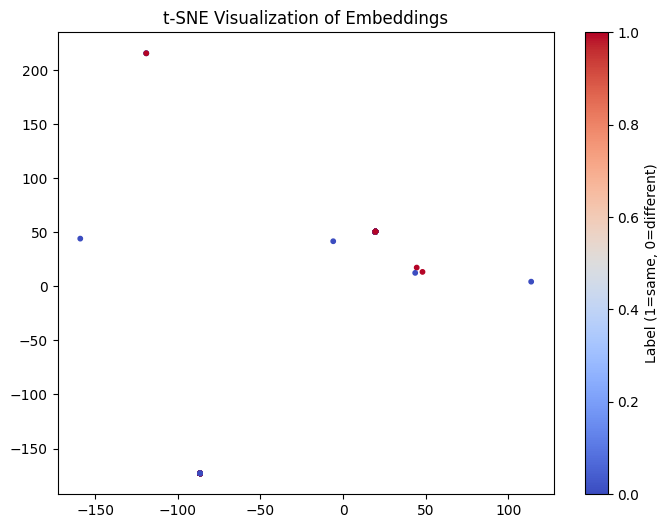

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from PIL import Image
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import random

# ---------- Siamese Dataset ----------
class SiameseFaceDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.class_to_indices = self._build_class_index()

    def _build_class_index(self):
        index = {}
        for i, label in enumerate(self.labels):
            index.setdefault(label, []).append(i)
        return index

    def __getitem__(self, index):
        img1 = self.images[index]
        label1 = self.labels[index]

        if random.random() > 0.5:
            label2 = label1
            idx2 = random.choice(self.class_to_indices[label1])
            target = 1
        else:
            label2 = random.choice([l for l in self.class_to_indices if l != label1])
            idx2 = random.choice(self.class_to_indices[label2])
            target = 0

        img2 = self.images[idx2]

        img1 = self.transform(Image.fromarray(np.uint8(img1)))
        img2 = self.transform(Image.fromarray(np.uint8(img2)))

        return img1, img2, torch.tensor([target], dtype=torch.float32)

    def __len__(self):
        return len(self.images)

# ---------- Siamese Network ----------
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        base_model = models.resnet18(pretrained=True)
        base_model.fc = nn.Linear(base_model.fc.in_features, 128)
        self.model = base_model

    def forward_once(self, x):
        return F.normalize(self.model(x), p=2, dim=1)

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2

# ---------- Contrastive Loss ----------
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        dist = F.pairwise_distance(output1, output2)
        loss = 0.5 * (label * dist**2 + (1 - label) * torch.clamp(self.margin - dist, min=0.0)**2)
        return loss.mean()

# ---------- Load Dataset ----------
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.images
y = lfw_people.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),  # اضافه شد
    transforms.ToTensor()
])

train_dataset = SiameseFaceDataset(X_train, y_train, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------- Initialize Model, Loss, Optimizer ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNet().to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ---------- Training Loop ----------
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for img1, img2, labels in loop:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        optimizer.zero_grad()
        out1, out2 = model(img1, img2)
        loss = criterion(out1, out2, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# ---------- Evaluation on Test Set ----------
test_dataset = SiameseFaceDataset(X_test, y_test, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

model.eval()
correct, total = 0, 0
threshold = 0.5  # Distance threshold for verification

with torch.no_grad():
    for img1, img2, labels in tqdm(test_loader, desc="Evaluating"):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        out1, out2 = model(img1, img2)
        dist = F.pairwise_distance(out1, out2)
        pred = (dist < threshold).float()
        correct += (pred == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
print(f"Verification Accuracy on Test Set: {accuracy:.2f}%")

# ---------- Optional: Visualize Embeddings ----------
from sklearn.manifold import TSNE

# Get embeddings for test images
all_embeddings = []
all_labels = []

with torch.no_grad():
    for img1, img2, labels in tqdm(test_loader, desc="Extracting Embeddings"):
        emb1 = model.forward_once(img1.to(device))
        all_embeddings.append(emb1.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

embeddings = np.vstack(all_embeddings)
labels = np.vstack(all_labels).flatten()

# Reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="coolwarm", s=10)
plt.title("t-SNE Visualization of Embeddings")
plt.colorbar(label="Label (1=same, 0=different)")
plt.show()